# Tutorial: 10X Visium dataset

## Loading package

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt

from stDGAC import stDGAC
from sklearn import metrics
from stDGAC.utils import clustering

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] = r'/usr/lib/R'

In [3]:
# dataset = '151507'
dataset = '151675'

## Read data

In [4]:
file_fold = '/mnt/Data/DLPFC/' + str(dataset)
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Running stDGAC

In [5]:
model = stDGAC.stDGAC(adata, device=device)
adata = model.train_stDGAC()

Begin to train...


100%|██████████| 600/600 [00:13<00:00, 45.27it/s]

Training finished!


## Spatial clustering

In [6]:
# For DLPFC dataset
if dataset in ['151669', '151670', '151671', '151672']:
    n_clusters = 5
else:
    n_clusters = 7
radius = 50
clustering(adata, n_clusters, radius=radius, refinement=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [7]:
# ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

In [8]:

ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI
print('===== Dataset: {}, ARI score: {:.4f}'.format(dataset, ARI))

Trying to set attribute `.uns` of view, copying.


===== Dataset: 151675, ARI score: 0.6130


... storing 'domain' as categorical
... storing 'ground_truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


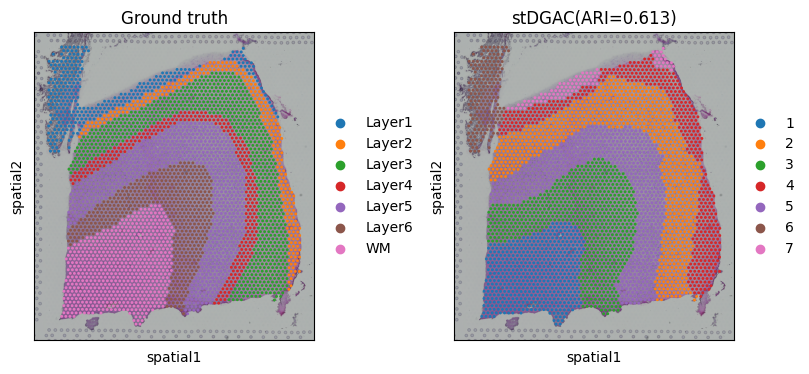

In [9]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.spatial(adata,
              img_key="hires", 
              color=["ground_truth", "domain"], 
              title=["Ground truth", "stDGAC(ARI=%.3f)"%ARI],
              show=True)

2023-11-08 08:44:37.156757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-08 08:44:38.068415: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-08 08:44:38.068541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-08 08:44:38.068555: W tensorfl

<AxesSubplot: title={'center': 'stDGAC'}, xlabel='UMAP1', ylabel='UMAP2'>

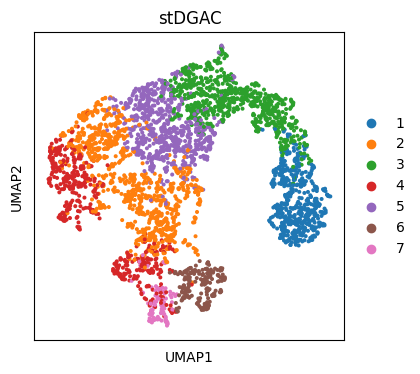

In [10]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['stDGAC'], show=False)